## Seminar 6
Today we compose the encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on Russian to English machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

### Imports

Install an additional **subword-nmt** package

In [0]:
#if you run in collab, uncomment this
! pip install subword_nmt

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import torch
import torch.nn as nn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data and preprocessing

Before we get to the architecture, we do some preprocessing.

1) The data will be tokenized with __WordPunctTokenizer__.

2) Create a dictionary (remember the previous seminar about Language Modelling)

But dictionary of what?

Our data lines contain unique rare words. If we operate on a word-level, we will have to deal with large vocabulary size. If instead, we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something in between.
One popular approach is called Byte Pair Encoding aka BPE. The algorithm starts with character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.

After preprocessing, we obtain files __\*.bpe.\*__ with tourists texts, splitting to BPE-tokens, and files of rules, which describes how every word in the vocabulary is split to tokens.



In [0]:
# uncomment this in collab
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://www.dropbox.com/s/fj9w01embfxvtw1/dummy_checkpoint.npz?dl=1 -O dummy_checkpoint.npz
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1op5MWlEiroEAXxsMR6AUkdNuG634JzYc' -O utils.py


--2019-12-04 16:50:11--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/yy2zqh34dyhv07i/data.txt [following]
--2019-12-04 16:50:11--  https://www.dropbox.com/s/dl/yy2zqh34dyhv07i/data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf8492952df9c9fc7b940b06a07.dl.dropboxusercontent.com/cd/0/get/AtnacyBjj1ldqMRGLWMPH82HXa4oTsdTps6FydbZ2T7xVYpanPYk8EwCpAX_BYwRrz92IcRVVypQqAKfWgeTf5e8_Upja8SqONLFIKKh0TXUXw/file?dl=1# [following]
--2019-12-04 16:50:11--  https://ucf8492952df9c9fc7b940b06a07.dl.dropboxusercontent.com/cd/0/get/AtnacyBjj1ldqMRGLWMPH82HXa4oTsdTps6FydbZ2T7xVYpanPYk8EwCpAX_BYwRrz92IcRVVypQqAKfWgeTf5e8_Upja8SqONLFIKKh0TXUXw/file?dl=1
Resolving ucf8492952d

In [0]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

In [0]:
!head train.bpe.en | tee head.txt

cor@@ del@@ ia hotel is situated in tbilisi , a 3 - minute walk away from saint trinity church .
at tu@@ pi@@ r@@ mar@@ ka lodge you will find a 24 - hour front desk , room service , and a snack bar .
featuring free wifi in all areas , nai@@ g@@ ao xiao@@ wo offers accommodation in shanghai .
each has a tv and a private bathroom with shower .
your room comes with air conditioning and satellite tv .
they are styled in cream - coloured hu@@ es and some of them feature private balconies with seating areas .
the reception team can help guests plan sightseeing trips .
some units include a seating area for your convenience .
ni@@ eu@@ w@@ markt as well as kal@@ ver@@ straat , hermitage and rem@@ brand@@ t@@ plein are within 15 minutes walking .
the danube delta is a natural reserve where you can go fishing , bird watching , take boat rides or simply unwind surrounded by nature .


### Split to train-dev
..and look at examples of data in train and dev

In [0]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



### Building vocabularies

In seminar 4 we build a vocabulary over tokens. 

On vocabulary base (**ids_to_token, token_to_ids**) we provide **to_matrix** function. Now this function and vocab class are in **util.py**. Besides **to_matrix** we provide **matrix_to_line**, which corresponds matrix of token indices to real line. 



__Vocab__ class and and its functionality works like this:

In [0]:
from utils import Vocab

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

Here's how you cast lines into ids and backwards.

In [0]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
[[   0 2688 2943 1108   29    1    1    1]
 [   0 2922 1834 8035   59 3800   29    1]
 [   0 6030 2083   29    1    1    1    1]
 [   0 4927 1870   29    1    1    1    1]
 [   0 5549 1453   27  592   29    1    1]]

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


We also define functions to compute lengths of every line in batch and create a mask for inference based on it (as in __seminar4__)

In [0]:
def sequence_mask(lengths, maxlen, dtype=torch.bool):
    """
    :param lenghts: array of size K, lenghts of input K lines
    :param maxlen: number of steps in our case
    """
    if maxlen is None:
        maxlen = lengths.max()
    cuda_check = lengths.is_cuda
    if cuda_check:
        cuda_device = lengths.get_device()
    
    one_tensor = torch.ones((len(lengths), maxlen))
    if (cuda_check):
        one_tensor = one_tensor.cuda(device=cuda_device)
    
    mask = ~(one_tensor.cumsum(dim=1).t() > lengths).t()
    mask.type(dtype)
    return mask

def infer_length(input_ix, eos_ix, time_major=False):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    """ Cont number of non-zero indexes """
    axis = 0 if time_major else 1
    a = input_ix.eq(eos_ix)
    count_eos = torch.cumsum(a, axis)
    lengths = torch.sum(count_eos.eq(0), axis)
    return lengths + 1 

def infer_mask(seq, eos_ix, time_major=False):
    """
    compute mask given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: mask, float32 matrix with '0's and '1's of same shape as seq
    """
    axis = 0 if time_major else 1
    lengths = infer_length(seq, eos_ix, time_major=time_major)
    mask = sequence_mask(lengths, maxlen=seq.size()[axis])
    if time_major: mask = mask.transpose(1, 0)
    return mask


### Simple encoder-decoder model

* The picture below contains a scheme for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything.

* The chain between encoder and decoder: In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.



![img](https://docs.google.com/uc?export=download&id=1srrm_If8MMWVoUl-qEJ1ieteC5dAwvhm)

* TRAIN MODE

When we train model and target lines are known, __out[i]__ is a i-th token from the corresponding target line.
It is function __decode()__ in the model below.

* GENERATE MODE

__out[i]__ is a previously generated token, obtain from previous logits (by __argmax__, for example) 
It is function __decode_inference()__

The picture describes **TRAIN_MODE**


In [0]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, device, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder model
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc.tokens), emb_size)
        self.emb_out = nn.Embedding(len(out_voc.tokens), emb_size)
        self.enc0 = nn.GRU(input_size = emb_size, hidden_size = hid_size, bidirectional = False, batch_first = True)

        self.dec0 = nn.GRU(input_size = emb_size, hidden_size = hid_size, bidirectional = False, batch_first = True)
        self.dec_dense = nn.Linear(hid_size, len(out_voc))
        self.logits = nn.LogSoftmax(dim=2)
        self.device = device
        
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hid_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        embedded = self.emb_inp(inp)
        output = embedded
        output, hidden = self.enc0(output)
        return output, hidden


    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_tokens = torch.unsqueeze(prev_tokens, 1)
        try:
            t_emp_out = self.emb_out(prev_tokens)
        except:
            print ("prev_tokens", prev_tokens)
        t_rnn_out, new_dec_state = self.dec0(t_emp_out, prev_state)
        output = self.dec_dense(t_rnn_out)
        output_logits = self.logits(output)
        
        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Run decoder on reference tokens (out_tokens) """
        """ TRAIN MODE """
        state = initial_state
        batch_size = out_tokens.shape[0]

        # initial logits: always predict BOS
        first_logits = torch.ones((batch_size, 1), dtype=torch.long).fill_(self.out_voc.bos_ix)

        first_logits_onehot = torch.Tensor(batch_size, len(self.out_voc)).zero_()

        first_logits_onehot.scatter_(1, first_logits, 1)
        
        first_logits = torch.log(first_logits_onehot + 1e-30).to(device)

        outputs = [torch.unsqueeze(first_logits, 1)]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            outputs.append(logits)
        return torch.cat(outputs, 1)

    def forward(self, inp, out):
        """ Apply model in training mode """
        encoder_output, encoder_hidden = self.encode(inp)
        
        return self.decode(encoder_hidden, out)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        """ GENERATE MODE """
        state = initial_state
        prev_elems = torch.ones(initial_state[0].shape[0]).to(self.device).to(torch.int64) * self.out_voc.bos_ix
        outputs = [prev_elems.unsqueeze(1)]
        all_states = [initial_state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1].squeeze()) 
            outputs.append(torch.argmax(logits, axis=-1))
            all_states.append(state)
        return torch.cat(outputs, 1), all_states

    def translate_lines(self, inp_lines):
        encoder_output, encoder_hidden = self.encode(inp_lines)
        out_ids, states = self.decode_inference(encoder_hidden)
        return np.array(out_voc.to_lines(out_ids.cpu().detach().numpy())), states


Test model creation and logits prediction:

In [0]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 
model = BasicModel(inp_voc, out_voc, device)
model.to(device)

BasicModel(
  (emb_inp): Embedding(8048, 64)
  (emb_out): Embedding(7801, 64)
  (enc0): GRU(64, 128, batch_first=True)
  (dec0): GRU(64, 128, batch_first=True)
  (dec_dense): Linear(in_features=128, out_features=7801, bias=True)
  (logits): LogSoftmax()
)

In [0]:
dummy_inp = torch.tensor(inp_voc.to_matrix(train_inp[:3])).to(torch.int64)
dummy_out = torch.tensor(out_voc.to_matrix(train_out[:3])).to(torch.int64)
dummy_logits = model(dummy_inp.to(device), dummy_out.to(device))
ref_shape = (dummy_out.shape[0], dummy_out.shape[1], len(out_voc))
assert dummy_logits.shape == ref_shape, "Your logits shape should be {} but got {}".format(dummy_logits.shape, ref_shape)
assert all(dummy_logits[:, 0].cpu().detach().numpy().argmax(-1) == out_voc.bos_ix), "first step must always be BOS"

In [0]:
dummy_inp.shape

torch.Size([3, 25])

### Training loss

Our training objetive is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

This loss is similar to ones in 4th seminar, but:

* instead of sum up over the sequence and than average between all lines in batch we __sum up token losses__ (excluding PAD tokens!) in all batch and __divide it to number of non-pad tokens__

In [0]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use infer_length or infer_mask)
    """
    
    
    seq_m = infer_mask(out, out_voc.eos_ix) # [batch_size, out_len]
    
    criterion = nn.CrossEntropyLoss(reduction='none')
    logits_seq = model(inp, out)

    logits_seq = logits_seq.permute(0, 2, 1)

    loss = criterion(logits_seq, out) # size [batch, num_of_step]
    loss = seq_m * loss
    loss = torch.sum(loss)
    
    return loss / torch.sum(seq_m)  # scalar

In [0]:
dummy_loss = compute_loss(model, dummy_inp.to(device), dummy_out.to(device))
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.cpu().detach().numpy(), 8.425, rtol=0.1, atol=0.1), "We're sorry for your loss"

Loss: tensor(8.4400, grad_fn=<DivBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
    translations = []
    batch_size = 30
    for index in range(int(len(inp_lines)/batch_size)):
      dev_inp_tensor = torch.tensor(inp_voc.to_matrix(inp_lines[index:index + batch_size])).to(torch.int64).to(device)
      translation = model.translate_lines(dev_inp_tensor, **flags)[0]
      translations.append(np.array(translation))
      del dev_inp_tensor
    translations = np.concatenate(translations, axis=0)
    #print (translations.shape)
    # Note: if you experience out-of-memory error, split input lines into batches and translate separately
    return corpus_bleu(
        [[ref.split()] for ref in out_lines],
        [trans.split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [0]:
compute_bleu(model, dev_inp, dev_out)

(3000,)


0.0018273646763056592

### Training parameters

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

Set optimizer, batch_size, vocabulary for loss and metrics for visualization.

In [0]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
batch_size = 32

In [0]:
print("Loss:", dummy_loss.cpu().detach().item())

Loss: 8.417143821716309


In [0]:
metrics['dev_bleu'].append(compute_bleu(model, dev_inp, dev_out))

(3000,)


## Training 
To achieve reasonable results, it is enough to do 5000 iterations

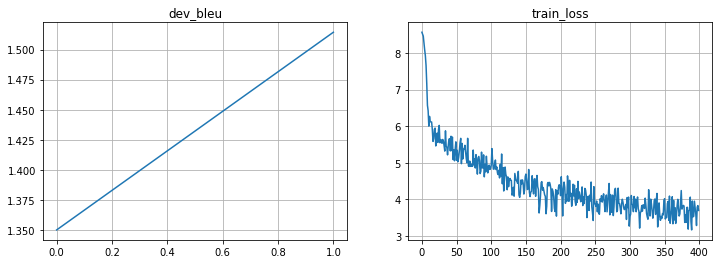

Mean loss=3.694


  2%|▏         | 400/25000 [07:36<59:50:03,  8.76s/it]

3.9790327548980713


  2%|▏         | 401/25000 [07:38<44:20:30,  6.49s/it]

3.33984375


  2%|▏         | 402/25000 [07:39<33:02:00,  4.83s/it]

3.2815730571746826


  2%|▏         | 403/25000 [07:40<25:14:58,  3.70s/it]

3.466057777404785


  2%|▏         | 404/25000 [07:41<19:42:33,  2.88s/it]

3.93691349029541


  2%|▏         | 405/25000 [07:41<15:18:48,  2.24s/it]

3.3605897426605225


  2%|▏         | 406/25000 [07:42<12:37:50,  1.85s/it]

KeyboardInterrupt: ignored

In [0]:
metrics = {'train_loss': [], 'dev_bleu': [] }

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
batch_size = 32


for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = torch.tensor(inp_voc.to_matrix(train_inp[batch_ix])).to(torch.int64).to(device)
    batch_out = torch.tensor(out_voc.to_matrix(train_out[batch_ix])).to(torch.int64).to(device)
    optimizer.zero_grad()
    loss_i = compute_loss(model, batch_inp, batch_out)
    print(loss_i.cpu().detach().item())
    metrics['train_loss'].append(loss_i.cpu().detach().item())
    
    if step % 200 == 0:
        metrics['dev_bleu'].append(compute_bleu(model, dev_inp, dev_out))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(history)
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0), flush=True)
        
    loss_i.backward()
    optimizer.step()

    
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [0]:
np.mean(metrics['train_loss'][-10:], axis=0)

3.5971691608428955

In [0]:
np.mean(metrics['dev_bleu'][-10:], axis=0)

1.4321797708537967

**Look at the translation.**
**Not bad, but not brilliant**

In [0]:
dev_inp_tensor = torch.tensor(inp_voc.to_matrix(dev_inp[::500])).to(torch.int64).to(device)
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp_tensor)[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
the property offers free parking .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the nearest airport is a 15 - minute drive away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
the property is a 5 - minute walk from the beach , while the nearest airport is located in the property .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the nearest airport is located in the property .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the property has a shower .



# Attention ... is all you need

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the leсture slides or [from this post] (https://distill.pub/2016/augmented-rnns/) or from [here],(https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

class __AttentionLayer__ works in __decode_step__ in common model.

* Input parameters:

  __enc_size__, __dec_size__ - size of hidden states from encoder and decoder respectively. Not equal in common case
  
  __hid_size__ - size of a_t 
  
  __enc__ - all sequence of **hidden_states** from encoder, bs * seq_len * enc_size
  
  __dec__ -  **hidden_state** from decoder, bs * dec_size
  
* Input parameters:

    __probas__ - weighst of every encoder state consider the decoder, *p_t*
    
    __attn__ - the weighted sum of encoder states, *attn*


In [0]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        self.activ = nn.Tanh()  

        self.linear_enc = nn.Linear(self.enc_size, self.hid_size) 
        self.linear_dec = nn.Linear(self.dec_size, self.hid_size) 
        self.linear_out = nn.Linear(self.hid_size, 1) 
        
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        
        
        # Compute logits
        lin_dec = self.linear_dec(dec[0])
        lin_enc = self.linear_enc(enc) # [batch, ninp, enc_size]
        lin_dec = lin_dec.unsqueeze(1) # [batch, 1, enc_size]
        scores = self.linear_out(self.activ(lin_enc + lin_dec))# [batch, ninp, 1] or [batch, ninp]
        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need tf.where
        masked_scores = torch.zeros(inp_mask.unsqueeze(2).shape) + 1e-9
        masked_scores[inp_mask] = scores[inp_mask] #[batch, ninp]

        # Compute attention probabilities (softmax)
        probs = self.softmax(masked_scores) # [batch, ninp]
        # Compute attention response using enc and probs
        exp = torch.matmul(probs.squeeze().unsqueeze(1), enc)
        attn = exp.squeeze() # [batch, enc_size]

        return attn, probs

In [0]:
m = AttentionLayer("my_sweet_attn", 128, 128, 128)

### Seq2seq model with attention

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attetion layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [0]:
class AttentiveModelLayer(BasicModel):
    def __init__(self, inp_voc, out_voc, device, emb_size=64, hid_size=128, attn_size = 128):
        """
        A simple encoder-decoder model
        """
        super().__init__(inp_voc, out_voc, device) # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc.tokens), emb_size)
        self.emb_out = nn.Embedding(len(out_voc.tokens), emb_size)
        self.enc0 = nn.GRU(input_size = emb_size, hidden_size = hid_size, bidirectional = False, batch_first = True)

        self.dec0 = nn.GRU(input_size = emb_size, hidden_size = hid_size, bidirectional = False, batch_first = True)
        self.dec_dense = nn.Linear(hid_size, len(out_voc))
        self.logits = nn.LogSoftmax(dim=2)
        self.device = device
        
        self.l_attention = AttentionLayer("Attention", hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        mask = infer_mask(inp, self.inp_voc.eos_ix)
        embedded = self.emb_inp(inp)
        output = embedded
        output, hidden = self.enc0(output)
        return output, hidden, embedded, mask


    def decode_step(self, prev_state, encoder_sequence, mask, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_tokens = torch.unsqueeze(prev_tokens, 1)
        t_emp_out = self.emb_out(prev_tokens)
        
        
        t_attention, t_probs = self.l_attention(encoder_sequence, prev_state, mask)
        
        t_rnn_out, new_dec_state = self.dec0(t_emp_out, prev_state)
        concat = torch.cat([t_rnn_out,t_attention.unsqueeze(1)],2)
        output = self.dec_dense(t_rnn_out)
        output_logits = self.logits(output)
        
        return new_dec_state, output_logits, t_probs

    def decode(self, initial_state, out_tokens, **flags):
        """ Run decoder on reference tokens (out_tokens) """
        """ TRAIN MODE """
        encoder_sequence, state, encoder_emb, mask = initial_state
        batch_size = out_tokens.shape[0]

        # initial logits: always predict BOS
        first_logits = torch.ones((batch_size, 1), dtype=torch.long).fill_(self.out_voc.bos_ix)

        first_logits_onehot = torch.Tensor(batch_size, len(self.out_voc)).zero_()

        first_logits_onehot.scatter_(1, first_logits, 1)
        
        first_logits = torch.log(first_logits_onehot + 1e-30).to(device)

        outputs = [torch.unsqueeze(first_logits, 1)]
        aprobs = [torch.zeros(mask.shape)]
        for i in range(out_tokens.shape[1] - 1):
            state, logits, aprob = self.decode_step(state, encoder_sequence, mask, out_tokens[:, i])
            outputs.append(logits)
            aprobs.append(aprob)
        return torch.cat(outputs, 1)

    def forward(self, inp, out):
        """ Apply model in training mode """
        encoder_output, encoder_hidden, embedded, mask = self.encode(inp)
        
        return self.decode((encoder_output, encoder_hidden, embedded, mask), out)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        """ GENERATE MODE """
        encoder_sequence, state, encoder_emb, mask = initial_state
        prev_elems = torch.ones(initial_state[0].shape[0]).to(self.device).to(torch.int64) * self.out_voc.bos_ix
        outputs = [prev_elems.unsqueeze(1)]
        all_states = [initial_state]
        aprobs = [torch.zeros(mask.shape)]
        for i in range(max_len):
            state, logits, aprob = self.decode_step(state, encoder_sequence, mask, outputs[-1].squeeze()) 
            outputs.append(torch.argmax(logits, axis=-1))
            all_states.append(state)
            aprobs.append(aprob)
        return torch.cat(outputs, 1), all_states, aprobs

    def translate_lines(self, inp_lines):
        encoder_information = self.encode(inp_lines)
        out_ids, states, aprobs = self.decode_inference(encoder_information)
        return out_voc.to_lines(out_ids.cpu().detach().numpy()), states, aprobs

In [0]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 
model = AttentiveModelLayer(inp_voc, out_voc, device)
model.to(device)
dummy_inp = torch.tensor(inp_voc.to_matrix(train_inp[:3])).to(torch.int64)
dummy_out = torch.tensor(out_voc.to_matrix(train_out[:3])).to(torch.int64)
dummy_logits = model(dummy_inp.to(device), dummy_out.to(device))

In [0]:
dummy_loss = compute_loss(model, dummy_inp, dummy_out)
print("Loss:", dummy_loss)

Loss: tensor(8.4232, grad_fn=<DivBackward0>)


In [0]:
from nltk.translate.bleu_score import corpus_bleu
compute_bleu(model, dev_inp, dev_out)

KeyboardInterrupt: ignored

### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

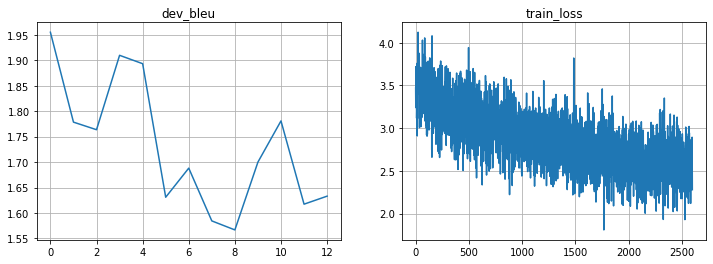

Mean loss=2.591






 10%|█         | 2600/25000 [1:00:24<94:50:35, 15.24s/it]

2.262108325958252






 10%|█         | 2601/25000 [1:00:25<68:06:30, 10.95s/it]

2.5783586502075195






 10%|█         | 2602/25000 [1:00:27<50:26:30,  8.11s/it]

2.6881465911865234






 10%|█         | 2603/25000 [1:00:28<37:46:14,  6.07s/it]

2.307492256164551






 10%|█         | 2604/25000 [1:00:29<28:24:08,  4.57s/it]

2.773730516433716






 10%|█         | 2605/25000 [1:00:30<21:51:51,  3.51s/it]

2.4635443687438965






 10%|█         | 2606/25000 [1:00:31<17:08:19,  2.76s/it]

2.654050350189209






 10%|█         | 2607/25000 [1:00:32<13:43:42,  2.21s/it]

2.57663631439209






 10%|█         | 2608/25000 [1:00:33<11:54:30,  1.91s/it]

2.431401491165161






 10%|█         | 2609/25000 [1:00:34<10:09:12,  1.63s/it]

2.5667829513549805






 10%|█         | 2610/25000 [1:00:35<9:04:00,  1.46s/it] 

2.581052780151367






 10%|█         | 2611/25000 [1:00:36<8:06:55,  1.30s/it]

2.7108333110809326






 10%|█         | 2612/25000 [1:00:37<7:22:37,  1.19s/it]

2.4731638431549072






 10%|█         | 2613/25000 [1:00:39<8:13:54,  1.32s/it]

2.609495162963867






 10%|█         | 2614/25000 [1:00:40<7:37:53,  1.23s/it]

2.4097516536712646






 10%|█         | 2615/25000 [1:00:41<6:50:11,  1.10s/it]

2.795398712158203






 10%|█         | 2616/25000 [1:00:42<6:51:57,  1.10s/it]

2.3903677463531494






 10%|█         | 2617/25000 [1:00:43<7:11:04,  1.16s/it]

2.1376700401306152






 10%|█         | 2618/25000 [1:00:44<6:39:04,  1.07s/it]

2.280337333679199






 10%|█         | 2619/25000 [1:00:45<6:20:39,  1.02s/it]

2.8808352947235107






 10%|█         | 2620/25000 [1:00:46<6:21:00,  1.02s/it]

2.303697347640991






 10%|█         | 2621/25000 [1:00:47<5:57:37,  1.04it/s]

2.5415055751800537






 10%|█         | 2622/25000 [1:00:48<6:23:38,  1.03s/it]

2.566624641418457






 10%|█         | 2623/25000 [1:00:49<6:50:44,  1.10s/it]

2.5232040882110596






 10%|█         | 2624/25000 [1:00:50<6:26:59,  1.04s/it]

2.1942243576049805






 10%|█         | 2625/25000 [1:00:51<6:20:56,  1.02s/it]

2.6649320125579834






 11%|█         | 2626/25000 [1:00:52<6:46:25,  1.09s/it]

2.3215129375457764






 11%|█         | 2627/25000 [1:00:53<6:35:11,  1.06s/it]

2.8687164783477783






 11%|█         | 2628/25000 [1:00:54<6:54:41,  1.11s/it]

3.0938570499420166






 11%|█         | 2629/25000 [1:00:55<6:40:11,  1.07s/it]

2.6214778423309326






 11%|█         | 2630/25000 [1:00:57<6:48:36,  1.10s/it]

2.3146157264709473






 11%|█         | 2631/25000 [1:00:57<6:22:56,  1.03s/it]

2.2983837127685547






 11%|█         | 2632/25000 [1:00:58<5:59:38,  1.04it/s]

2.650014638900757






 11%|█         | 2633/25000 [1:01:00<7:14:33,  1.17s/it]

2.4982283115386963






 11%|█         | 2634/25000 [1:01:01<7:04:56,  1.14s/it]

2.757366895675659






 11%|█         | 2635/25000 [1:01:02<7:39:07,  1.23s/it]

2.5618419647216797






 11%|█         | 2636/25000 [1:01:04<7:29:46,  1.21s/it]

2.4696943759918213






 11%|█         | 2637/25000 [1:01:05<7:20:56,  1.18s/it]

2.6311843395233154






 11%|█         | 2638/25000 [1:01:06<8:03:39,  1.30s/it]

2.8118808269500732






 11%|█         | 2639/25000 [1:01:07<7:45:51,  1.25s/it]

2.3026609420776367






 11%|█         | 2640/25000 [1:01:08<7:14:42,  1.17s/it]

2.767656087875366






 11%|█         | 2641/25000 [1:01:10<7:27:20,  1.20s/it]

2.676745891571045






 11%|█         | 2642/25000 [1:01:11<7:25:51,  1.20s/it]

2.666405200958252






 11%|█         | 2643/25000 [1:01:12<7:02:38,  1.13s/it]

2.182321071624756






 11%|█         | 2644/25000 [1:01:13<6:36:12,  1.06s/it]

2.452739715576172






 11%|█         | 2645/25000 [1:01:14<7:18:38,  1.18s/it]

2.501488447189331






 11%|█         | 2646/25000 [1:01:15<7:11:20,  1.16s/it]

2.2770626544952393






 11%|█         | 2647/25000 [1:01:16<7:02:56,  1.14s/it]

2.2828385829925537






 11%|█         | 2648/25000 [1:01:17<6:41:33,  1.08s/it]

2.5546529293060303






 11%|█         | 2649/25000 [1:01:18<6:43:52,  1.08s/it]

2.4751360416412354






 11%|█         | 2650/25000 [1:01:20<7:15:01,  1.17s/it]

2.556835889816284






 11%|█         | 2651/25000 [1:01:21<7:19:08,  1.18s/it]

2.7018890380859375






 11%|█         | 2652/25000 [1:01:22<7:10:18,  1.16s/it]

2.5087246894836426






 11%|█         | 2653/25000 [1:01:23<6:54:15,  1.11s/it]

2.6466307640075684






 11%|█         | 2654/25000 [1:01:24<7:01:46,  1.13s/it]

2.4016218185424805






 11%|█         | 2655/25000 [1:01:25<6:21:08,  1.02s/it]

2.2419769763946533






 11%|█         | 2656/25000 [1:01:26<6:02:15,  1.03it/s]

2.480372428894043






 11%|█         | 2657/25000 [1:01:27<5:55:37,  1.05it/s]

2.582184076309204






 11%|█         | 2658/25000 [1:01:28<6:24:21,  1.03s/it]

2.2045440673828125






 11%|█         | 2659/25000 [1:01:29<5:54:32,  1.05it/s]

2.521812915802002






 11%|█         | 2660/25000 [1:01:30<6:08:37,  1.01it/s]

2.3280208110809326






 11%|█         | 2661/25000 [1:01:31<6:29:25,  1.05s/it]

2.4743268489837646






 11%|█         | 2662/25000 [1:01:32<6:34:05,  1.06s/it]

2.613943576812744






 11%|█         | 2663/25000 [1:01:33<6:58:30,  1.12s/it]

2.5751397609710693






 11%|█         | 2664/25000 [1:01:34<6:39:23,  1.07s/it]

2.9287965297698975






 11%|█         | 2665/25000 [1:01:36<8:16:59,  1.34s/it]

2.844931125640869






 11%|█         | 2666/25000 [1:01:37<7:48:08,  1.26s/it]

2.6467514038085938






 11%|█         | 2667/25000 [1:01:38<6:57:52,  1.12s/it]

2.3053905963897705






 11%|█         | 2668/25000 [1:01:39<6:50:13,  1.10s/it]

2.7514424324035645






 11%|█         | 2669/25000 [1:01:41<7:10:06,  1.16s/it]

2.4677889347076416






 11%|█         | 2670/25000 [1:01:42<7:13:20,  1.16s/it]

2.548734426498413






 11%|█         | 2671/25000 [1:01:43<7:20:24,  1.18s/it]

2.378909111022949






 11%|█         | 2672/25000 [1:01:44<6:57:43,  1.12s/it]

2.779677391052246






 11%|█         | 2673/25000 [1:01:46<8:06:52,  1.31s/it]

2.9101860523223877






 11%|█         | 2674/25000 [1:01:47<7:21:29,  1.19s/it]

2.621907949447632






 11%|█         | 2675/25000 [1:01:48<7:13:10,  1.16s/it]

2.490241289138794






 11%|█         | 2676/25000 [1:01:48<6:30:04,  1.05s/it]

2.273606300354004






 11%|█         | 2677/25000 [1:01:50<7:00:45,  1.13s/it]

2.4904985427856445






 11%|█         | 2678/25000 [1:01:51<7:03:50,  1.14s/it]

2.5084168910980225






 11%|█         | 2679/25000 [1:01:52<7:27:32,  1.20s/it]

2.685476303100586






 11%|█         | 2680/25000 [1:01:54<8:59:33,  1.45s/it]

3.0793278217315674






 11%|█         | 2681/25000 [1:01:55<8:04:42,  1.30s/it]

2.7303826808929443






 11%|█         | 2682/25000 [1:01:57<8:15:48,  1.33s/it]

2.0832386016845703






 11%|█         | 2683/25000 [1:01:58<7:31:13,  1.21s/it]

3.034245014190674






 11%|█         | 2684/25000 [1:01:59<7:57:24,  1.28s/it]

2.1457817554473877






 11%|█         | 2685/25000 [1:02:00<7:32:42,  1.22s/it]

2.315847635269165






 11%|█         | 2686/25000 [1:02:01<7:10:12,  1.16s/it]

2.424329996109009






 11%|█         | 2687/25000 [1:02:02<6:53:39,  1.11s/it]

2.6301372051239014






 11%|█         | 2688/25000 [1:02:03<6:38:43,  1.07s/it]

2.621079921722412






 11%|█         | 2689/25000 [1:02:05<8:14:49,  1.33s/it]

2.4802846908569336






 11%|█         | 2690/25000 [1:02:06<7:39:44,  1.24s/it]

2.077761173248291






 11%|█         | 2691/25000 [1:02:07<7:24:19,  1.20s/it]

2.667482376098633






 11%|█         | 2692/25000 [1:02:08<6:38:52,  1.07s/it]

2.168149709701538






 11%|█         | 2693/25000 [1:02:09<6:22:46,  1.03s/it]

2.642159938812256






 11%|█         | 2694/25000 [1:02:10<6:27:28,  1.04s/it]

2.5003838539123535






 11%|█         | 2695/25000 [1:02:11<6:25:29,  1.04s/it]

2.5560338497161865






 11%|█         | 2696/25000 [1:02:12<6:13:16,  1.00s/it]

2.616722822189331






 11%|█         | 2697/25000 [1:02:13<6:55:25,  1.12s/it]

2.497556686401367






 11%|█         | 2698/25000 [1:02:14<6:33:35,  1.06s/it]

2.0863749980926514






 11%|█         | 2699/25000 [1:02:15<6:29:56,  1.05s/it]

2.4901225566864014






 11%|█         | 2700/25000 [1:02:16<6:09:40,  1.01it/s]

2.4544363021850586






 11%|█         | 2701/25000 [1:02:17<5:52:40,  1.05it/s]

2.687011957168579






 11%|█         | 2702/25000 [1:02:18<6:34:13,  1.06s/it]

1.993692398071289






 11%|█         | 2703/25000 [1:02:19<6:04:13,  1.02it/s]

2.79589581489563






 11%|█         | 2704/25000 [1:02:21<8:31:55,  1.38s/it]

2.722611665725708






 11%|█         | 2705/25000 [1:02:22<8:03:57,  1.30s/it]

2.5843963623046875






 11%|█         | 2706/25000 [1:02:23<7:11:09,  1.16s/it]

2.2682125568389893






 11%|█         | 2707/25000 [1:02:24<6:41:31,  1.08s/it]

2.639233350753784






 11%|█         | 2708/25000 [1:02:25<6:50:09,  1.10s/it]

2.3587327003479004






 11%|█         | 2709/25000 [1:02:27<6:58:12,  1.13s/it]

2.7889044284820557






 11%|█         | 2710/25000 [1:02:28<7:46:00,  1.25s/it]

2.90974497795105






 11%|█         | 2711/25000 [1:02:29<7:31:48,  1.22s/it]

2.8279855251312256






 11%|█         | 2712/25000 [1:02:31<8:36:44,  1.39s/it]

2.682379722595215






 11%|█         | 2713/25000 [1:02:32<8:02:56,  1.30s/it]

2.4298362731933594






 11%|█         | 2714/25000 [1:02:33<7:38:57,  1.24s/it]

2.7250919342041016






 11%|█         | 2715/25000 [1:02:34<7:29:14,  1.21s/it]

2.4743337631225586






 11%|█         | 2716/25000 [1:02:36<7:44:45,  1.25s/it]

2.392282009124756






 11%|█         | 2717/25000 [1:02:37<7:16:04,  1.17s/it]

2.1300463676452637






 11%|█         | 2718/25000 [1:02:38<7:04:39,  1.14s/it]

2.2899329662323






 11%|█         | 2719/25000 [1:02:39<6:34:43,  1.06s/it]

2.1269712448120117






 11%|█         | 2720/25000 [1:02:40<6:27:00,  1.04s/it]

2.4977824687957764






 11%|█         | 2721/25000 [1:02:40<5:56:09,  1.04it/s]

2.6112406253814697






 11%|█         | 2722/25000 [1:02:41<5:46:47,  1.07it/s]

2.3925797939300537






 11%|█         | 2723/25000 [1:02:42<5:29:56,  1.13it/s]

2.317964792251587






 11%|█         | 2724/25000 [1:02:43<5:58:18,  1.04it/s]

2.5391669273376465






 11%|█         | 2725/25000 [1:02:44<6:18:11,  1.02s/it]

2.2560718059539795






 11%|█         | 2726/25000 [1:02:46<6:40:52,  1.08s/it]

1.7991001605987549






 11%|█         | 2727/25000 [1:02:46<6:18:29,  1.02s/it]

2.5142741203308105






 11%|█         | 2728/25000 [1:02:47<6:23:31,  1.03s/it]

2.752176523208618






 11%|█         | 2729/25000 [1:02:49<6:57:35,  1.13s/it]

2.7880489826202393






 11%|█         | 2730/25000 [1:02:50<6:53:55,  1.12s/it]

2.793531656265259






 11%|█         | 2731/25000 [1:02:51<6:57:30,  1.12s/it]

2.555797576904297






 11%|█         | 2732/25000 [1:02:52<7:16:39,  1.18s/it]

2.644055128097534






 11%|█         | 2733/25000 [1:02:54<7:11:41,  1.16s/it]

2.8442330360412598






 11%|█         | 2734/25000 [1:02:56<8:44:42,  1.41s/it]

2.818437337875366






 11%|█         | 2735/25000 [1:02:56<7:32:55,  1.22s/it]

2.5454306602478027






 11%|█         | 2736/25000 [1:02:57<7:15:33,  1.17s/it]

2.0173091888427734






 11%|█         | 2737/25000 [1:02:58<6:31:29,  1.06s/it]

2.3480494022369385






 11%|█         | 2738/25000 [1:02:59<6:19:24,  1.02s/it]

2.1405529975891113






 11%|█         | 2739/25000 [1:03:00<7:04:24,  1.14s/it]

2.674788236618042






 11%|█         | 2740/25000 [1:03:02<6:59:08,  1.13s/it]

2.0887093544006348






 11%|█         | 2741/25000 [1:03:02<6:20:30,  1.03s/it]

2.556297779083252






 11%|█         | 2742/25000 [1:03:03<5:53:07,  1.05it/s]

2.659101963043213






 11%|█         | 2743/25000 [1:03:04<6:00:27,  1.03it/s]

2.5248217582702637






 11%|█         | 2744/25000 [1:03:05<5:55:27,  1.04it/s]

2.38382625579834






 11%|█         | 2745/25000 [1:03:06<6:21:44,  1.03s/it]

2.7547521591186523






 11%|█         | 2746/25000 [1:03:07<6:33:13,  1.06s/it]

3.033454418182373






 11%|█         | 2747/25000 [1:03:09<6:38:51,  1.08s/it]

2.3461861610412598






 11%|█         | 2748/25000 [1:03:10<6:56:33,  1.12s/it]

2.628755807876587






 11%|█         | 2749/25000 [1:03:11<6:55:35,  1.12s/it]

2.7517592906951904






 11%|█         | 2750/25000 [1:03:12<7:29:26,  1.21s/it]

2.187838077545166






 11%|█         | 2751/25000 [1:03:14<8:06:06,  1.31s/it]

2.0926263332366943






 11%|█         | 2752/25000 [1:03:15<7:18:16,  1.18s/it]

2.689323663711548






 11%|█         | 2753/25000 [1:03:16<6:43:05,  1.09s/it]

2.421959638595581






 11%|█         | 2754/25000 [1:03:17<6:45:43,  1.09s/it]

2.560532808303833






 11%|█         | 2755/25000 [1:03:18<7:20:50,  1.19s/it]

2.9359560012817383






 11%|█         | 2756/25000 [1:03:19<7:11:39,  1.16s/it]

2.1382930278778076






 11%|█         | 2757/25000 [1:03:20<6:42:29,  1.09s/it]

2.458688259124756






 11%|█         | 2758/25000 [1:03:21<6:37:30,  1.07s/it]

2.5267460346221924






 11%|█         | 2759/25000 [1:03:22<6:38:43,  1.08s/it]

3.146200180053711






 11%|█         | 2760/25000 [1:03:23<6:25:49,  1.04s/it]

2.7152087688446045






 11%|█         | 2761/25000 [1:03:24<6:22:29,  1.03s/it]

2.779750347137451






 11%|█         | 2762/25000 [1:03:25<6:20:11,  1.03s/it]

2.219161033630371






 11%|█         | 2763/25000 [1:03:26<6:47:02,  1.10s/it]

2.3038017749786377






 11%|█         | 2764/25000 [1:03:27<6:11:24,  1.00s/it]

2.3032174110412598






 11%|█         | 2765/25000 [1:03:28<6:18:27,  1.02s/it]

2.3078224658966064






 11%|█         | 2766/25000 [1:03:29<5:52:21,  1.05it/s]

2.1323487758636475






 11%|█         | 2767/25000 [1:03:30<6:06:39,  1.01it/s]

2.228769302368164






 11%|█         | 2768/25000 [1:03:31<6:05:16,  1.01it/s]

2.318459987640381






 11%|█         | 2769/25000 [1:03:32<5:44:40,  1.07it/s]

2.436432123184204






 11%|█         | 2770/25000 [1:03:33<6:12:50,  1.01s/it]

2.590263843536377






 11%|█         | 2771/25000 [1:03:34<6:23:58,  1.04s/it]

2.3645830154418945






 11%|█         | 2772/25000 [1:03:35<5:57:54,  1.04it/s]

2.764437675476074






 11%|█         | 2773/25000 [1:03:36<6:17:04,  1.02s/it]

2.240687608718872






 11%|█         | 2774/25000 [1:03:37<5:59:53,  1.03it/s]

2.7069664001464844






 11%|█         | 2775/25000 [1:03:38<5:51:55,  1.05it/s]

2.4590823650360107






 11%|█         | 2776/25000 [1:03:39<6:52:57,  1.11s/it]

2.6529622077941895






 11%|█         | 2777/25000 [1:03:41<6:50:55,  1.11s/it]

2.3404624462127686






 11%|█         | 2778/25000 [1:03:42<6:53:15,  1.12s/it]

2.524486780166626






 11%|█         | 2779/25000 [1:03:43<6:19:27,  1.02s/it]

2.874802827835083






 11%|█         | 2780/25000 [1:03:44<6:27:24,  1.05s/it]

2.5969364643096924






 11%|█         | 2781/25000 [1:03:45<6:55:45,  1.12s/it]

2.8786239624023438






 11%|█         | 2782/25000 [1:03:46<6:35:53,  1.07s/it]

2.6624603271484375






 11%|█         | 2783/25000 [1:03:47<6:19:41,  1.03s/it]

2.322329521179199






 11%|█         | 2784/25000 [1:03:48<6:13:36,  1.01s/it]

2.6570589542388916






 11%|█         | 2785/25000 [1:03:49<6:35:52,  1.07s/it]

2.4109859466552734






 11%|█         | 2786/25000 [1:03:50<7:02:48,  1.14s/it]

2.4863476753234863






 11%|█         | 2787/25000 [1:03:52<7:13:52,  1.17s/it]

2.5329694747924805






 11%|█         | 2788/25000 [1:03:52<6:41:05,  1.08s/it]

2.305105447769165






 11%|█         | 2789/25000 [1:03:53<6:23:43,  1.04s/it]

2.379995822906494






 11%|█         | 2790/25000 [1:03:54<6:35:25,  1.07s/it]

2.371246337890625






 11%|█         | 2791/25000 [1:03:55<6:04:00,  1.02it/s]

2.661808729171753






 11%|█         | 2792/25000 [1:03:56<6:07:16,  1.01it/s]

2.9436192512512207






 11%|█         | 2793/25000 [1:03:57<6:10:14,  1.00s/it]

2.4686074256896973






 11%|█         | 2794/25000 [1:03:58<6:00:53,  1.03it/s]

2.3967444896698






 11%|█         | 2795/25000 [1:03:59<5:55:10,  1.04it/s]

2.6638612747192383






 11%|█         | 2796/25000 [1:04:00<5:23:28,  1.14it/s]

2.4710023403167725






 11%|█         | 2797/25000 [1:04:01<5:38:24,  1.09it/s]

2.5009865760803223






 11%|█         | 2798/25000 [1:04:02<6:10:31,  1.00s/it]

2.8855133056640625






 11%|█         | 2799/25000 [1:04:04<8:03:42,  1.31s/it]

2.6678030490875244


KeyboardInterrupt: ignored

In [0]:
metrics = {'train_loss': [], 'dev_bleu': [] }

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
batch_size = 32


for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = torch.tensor(inp_voc.to_matrix(train_inp[batch_ix])).to(torch.int64).to(device)
    batch_out = torch.tensor(out_voc.to_matrix(train_out[batch_ix])).to(torch.int64).to(device)
    optimizer.zero_grad()
    loss_i = compute_loss(model, batch_inp, batch_out)
    print(loss_i.cpu().detach().item())
    metrics['train_loss'].append(loss_i.cpu().detach().item())
    
    if step % 200 == 0:
        metrics['dev_bleu'].append(compute_bleu(model, dev_inp, dev_out))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(history)
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0), flush=True)
        
    loss_i.backward()
    optimizer.step()


In [0]:
dev_inp_tensor = torch.tensor(inp_voc.to_matrix(dev_inp[::500])).to(torch.int64).to(device)
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp_tensor)[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen , while a shared lounge is available .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bike hire and car hire are available at the property and the area is popular for cycling .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the property is 1 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of kazan , this apartment features a terrace , a garden and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in the heart of the city , this apartment features a balcony with sea views .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower and free toiletries .



### See to attention map

In [0]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [0]:
dev_inp_tensor = torch.tensor(inp_voc.to_matrix(dev_inp[::500])).to(torch.int64).to(device)
trans, states, attn_probs = model.translate_lines(dev_inp_tensor)


In [0]:
attention_probs.squeeze().shape

(6, 100, 32)

In [0]:
attn_probs[1].shape

torch.Size([6, 32, 1])

In [0]:
attention_probs = np.stack([attention_prob.cpu().detach().numpy() for attention_prob in attn_probs[1:]], axis=1)
attention_probs = attention_probs.squeeze()

for i in [0,10,20]:
    draw_attention(dev_inp[i], trans[i], attention_probs[i, :, :])

IndexError: ignored